<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 104</h1>
<h1>Impact of Seasonal effects on CoVID19</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from EpiModel import *

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

matplotlib 3.1.3
pandas     1.0.1
numpy      1.18.1
cartopy    0.18.0
json       2.0.9
watermark  2.0.2
scipy      1.4.1
networkx   2.4
autopep8   1.5
Sun Jun 21 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : faef23e22b9a44430143099ca013ff07cbbafda2


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Seasonality

We define a simple function to implement the seasonality curve based on the usual parameters

In [4]:
def seasonality(a_max=1.1, a_min=0.1, t_max=15):
    t = np.arange(1, 366)
    return a_min+1/2*(1+np.cos(2*np.pi/365*(t-t_max)))*(a_max-a_min)

In [5]:
dates = pd.date_range('2020-01-01', '2020-12-30')
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_extended = months.copy()
months_extended.extend(months[:3])

And create a quick representation of the three common seasonality curves considered t

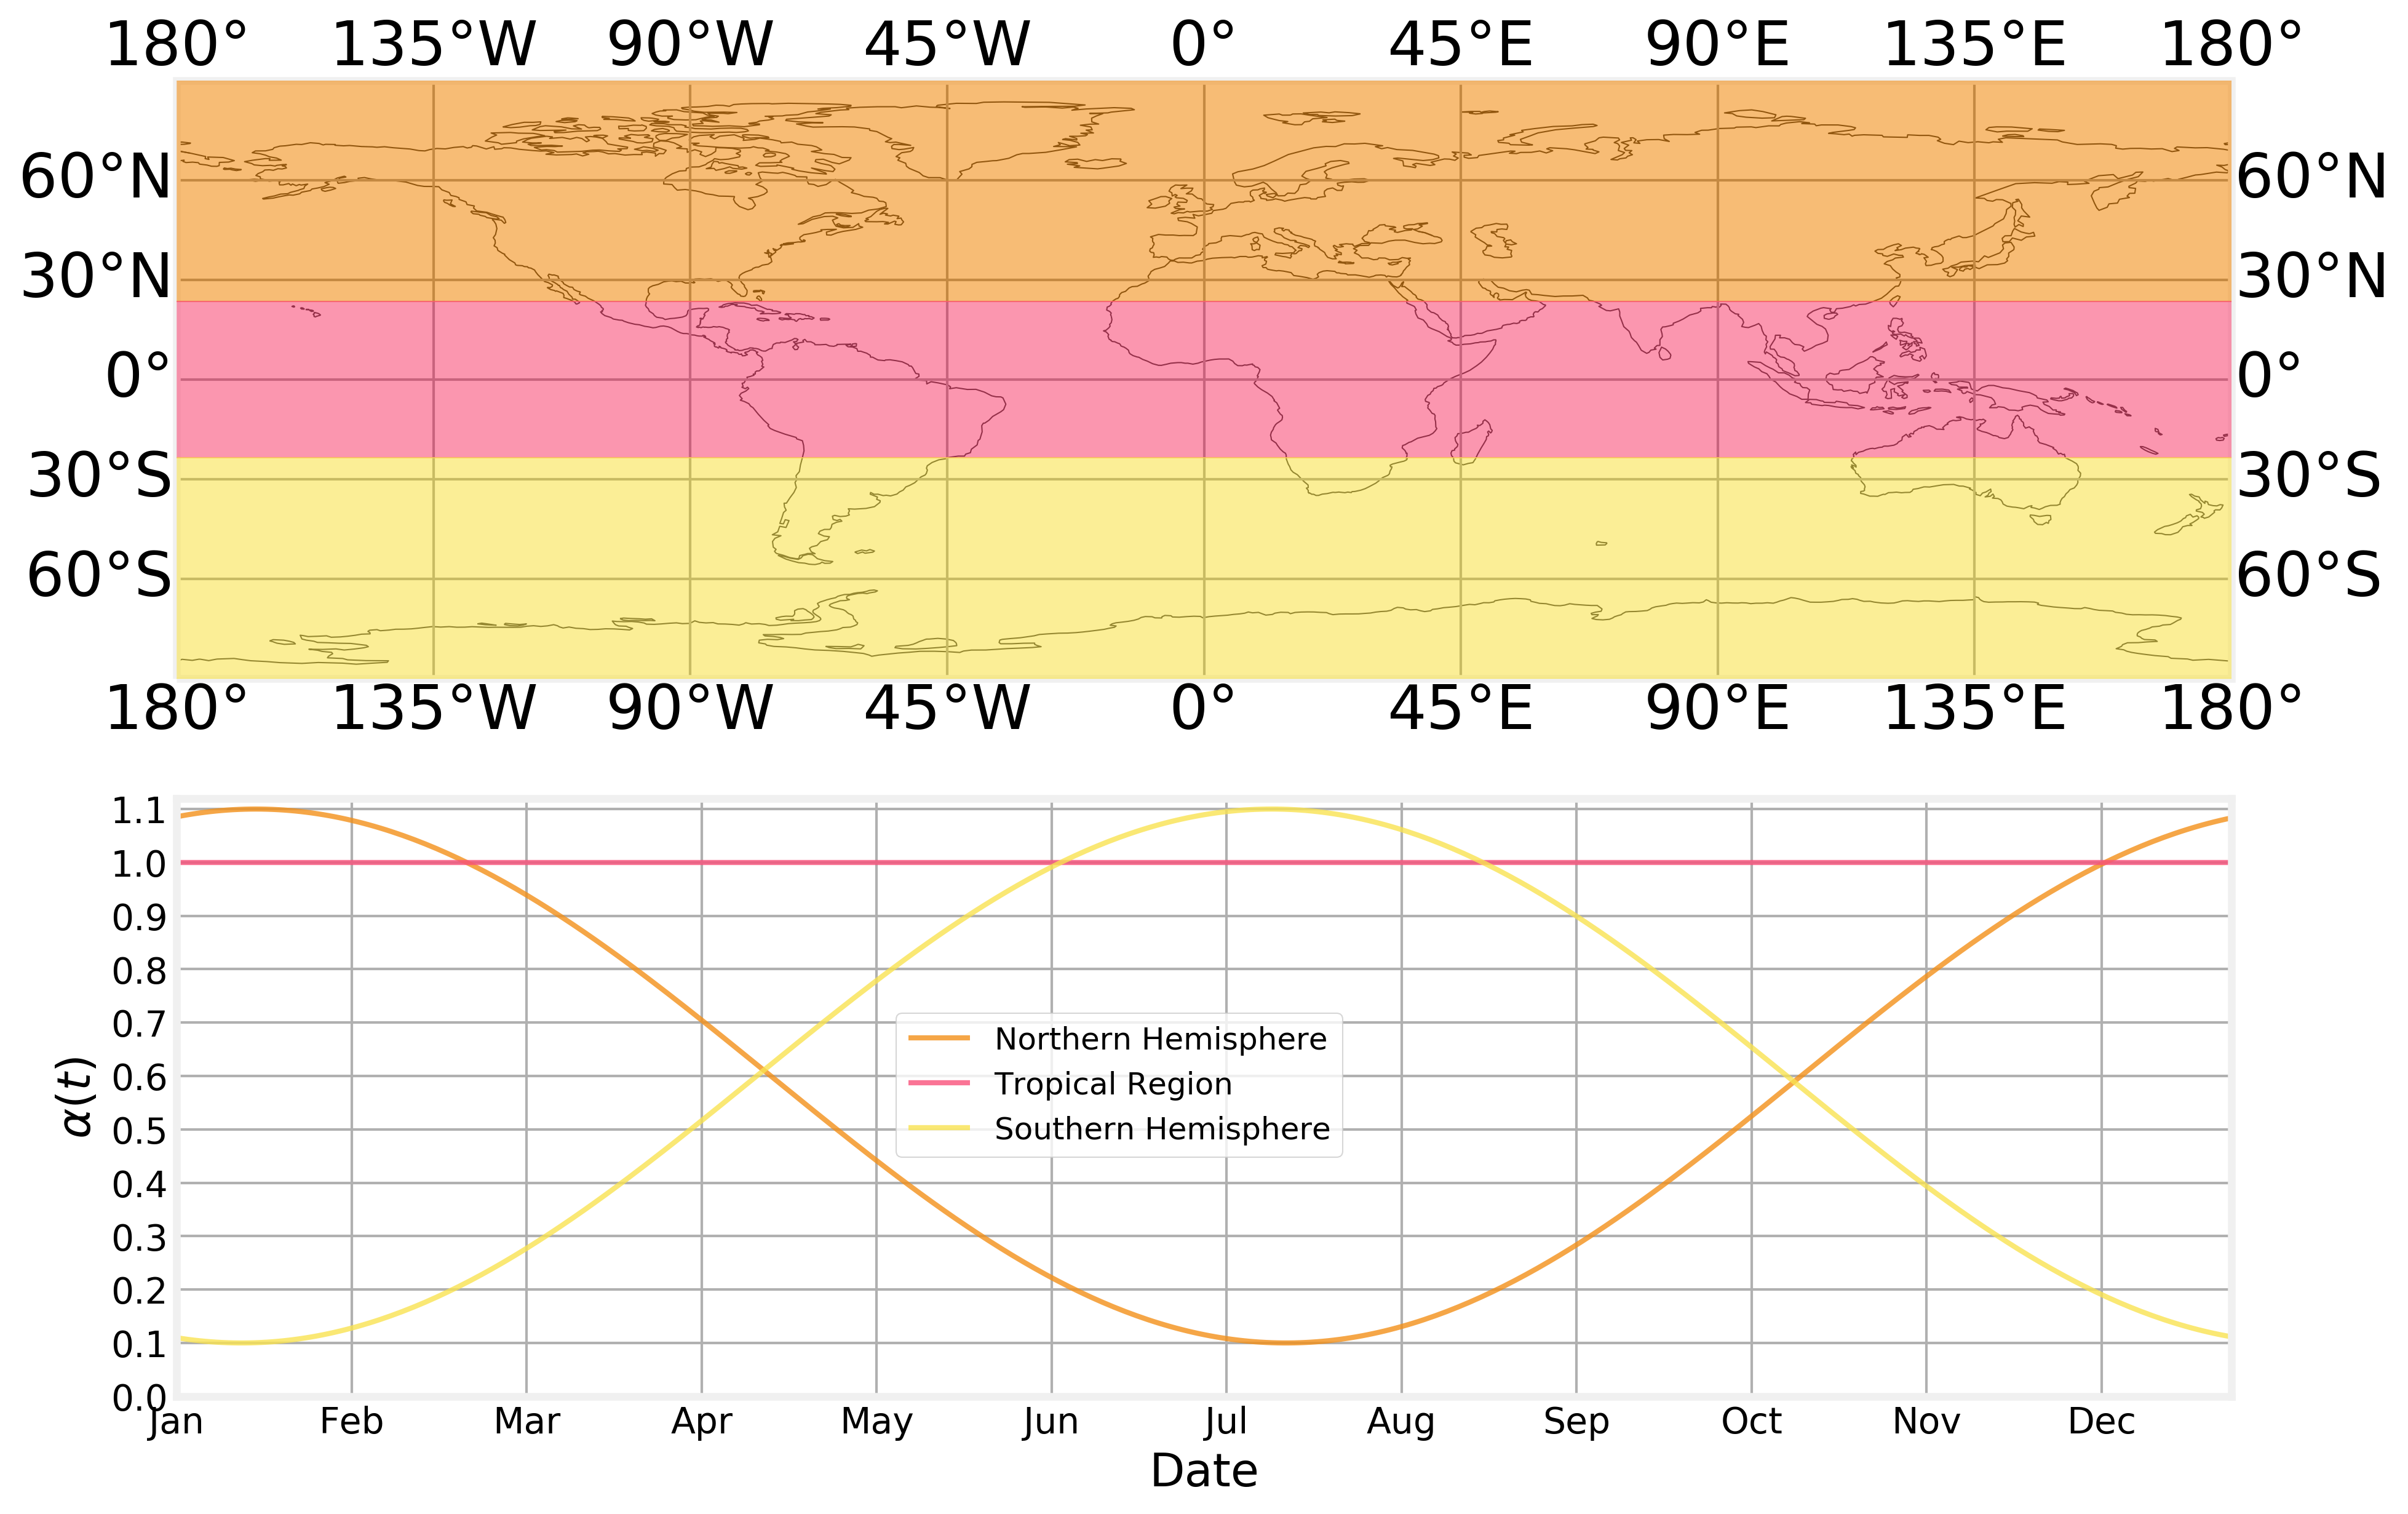

In [6]:
ax = [plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(), aspect='auto'), 
      plt.subplot(2, 1, 2)]
fig = plt.gcf()

ax[0].set_global()
ax[0].coastlines()


ax[0].axhspan(xmin=-180, xmax=180, ymin=23.5, ymax=90, color=colors[3], alpha=.6, label='Northern Hemisphere', zorder=5)
ax[0].axhspan(xmin=-180, xmax=180, ymin=-23.5, ymax=23.5, color=colors[5], alpha=.6, label='Tropical Region', zorder=5)
ax[0].axhspan(xmin=-180, xmax=180, ymin=-90, ymax=-23.5, color=colors[4], alpha=.6, label='Southern Hemisphere', zorder=5)

ax[0].gridlines(draw_labels=True, dms=True, 
             xlocs=np.arange(-180, 180.1, 45), 
             ylocs=np.arange(-90, 90.1, 30),
             x_inline=False, y_inline=False, color='gray')

ax[1].plot(dates, seasonality(), label='Northern Hemisphere', c=colors[3], alpha=0.8, lw=2)
ax[1].plot(dates, np.ones(365), label='Tropical Region', c=colors[5], alpha=0.8, lw=2)
ax[1].plot(dates, seasonality(t_max=195), label='Southern Hemisphere', c=colors[4], alpha=0.8, lw=2)

ax[1].set_xticks(dates[0::31], False)
ax[1].set_xticklabels(months, fontsize=14)
ax[1].set_xlabel('Date', fontsize=18)
ax[1].set_ylabel(r'$\alpha\left(t\right)$', fontsize=18)
ax[1].set_xlim(dates[0], dates[-1])
ax[1].set_ylim(0, 1.12)
ax[1].set_yticks(np.arange(0, 1.11, 0.1))
ax[1].set_yticklabels(np.around(np.arange(0, 1.11, 0.1), 1), fontsize=14)
ax[1].legend(loc=(0.35, 0.4), fontsize=12)

plt.tight_layout()

## CoVID19 Model

We start by reintroducing the SEIIRD model as it contains enough features to be (somewhat) realistic while still being relatively simple to understand

In [7]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.0

beta = R0*mu/(pa*rbeta+(1-pa))

SEIIRD = EpiModel()
SEIIRD.add_interaction('S', 'E', 'Ia', rbeta*beta)
SEIIRD.add_interaction('S', 'E', 'Is', beta)
SEIIRD.add_spontaneous('E', 'Ia', epsilon*pa)
SEIIRD.add_spontaneous('E', 'Is', epsilon*(1-pa))
SEIIRD.add_spontaneous('Ia', 'R', mu)
SEIIRD.add_spontaneous('Is', 'R', (1-pD)*mu)
SEIIRD.add_spontaneous('Is', 'D', pD*mu)

The model contains 7 different transitions across 6 compartments:

In [8]:
print(SEIIRD)

Epidemic Model with 6 compartments and 7 transitions:

S + Ia = E 0.166667
S + Is = E 0.222222
E -> Ia 0.160000
E -> Is 0.240000
Ia -> R 0.100000
Is -> R 0.090000
Is -> D 0.010000

R0=2.00


Define our initial population

In [9]:
N = 100000
I0 = 10

And integrate the model. Here we do not consider any seasonal forcing so we'll use this as a baseline and is also equivalent to what happens in the Tropical region

In [10]:
SEIIRD.integrate(365, S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
non_seasonal = SEIIRD.values_.copy()

Text(0, 0.5, 'Population')

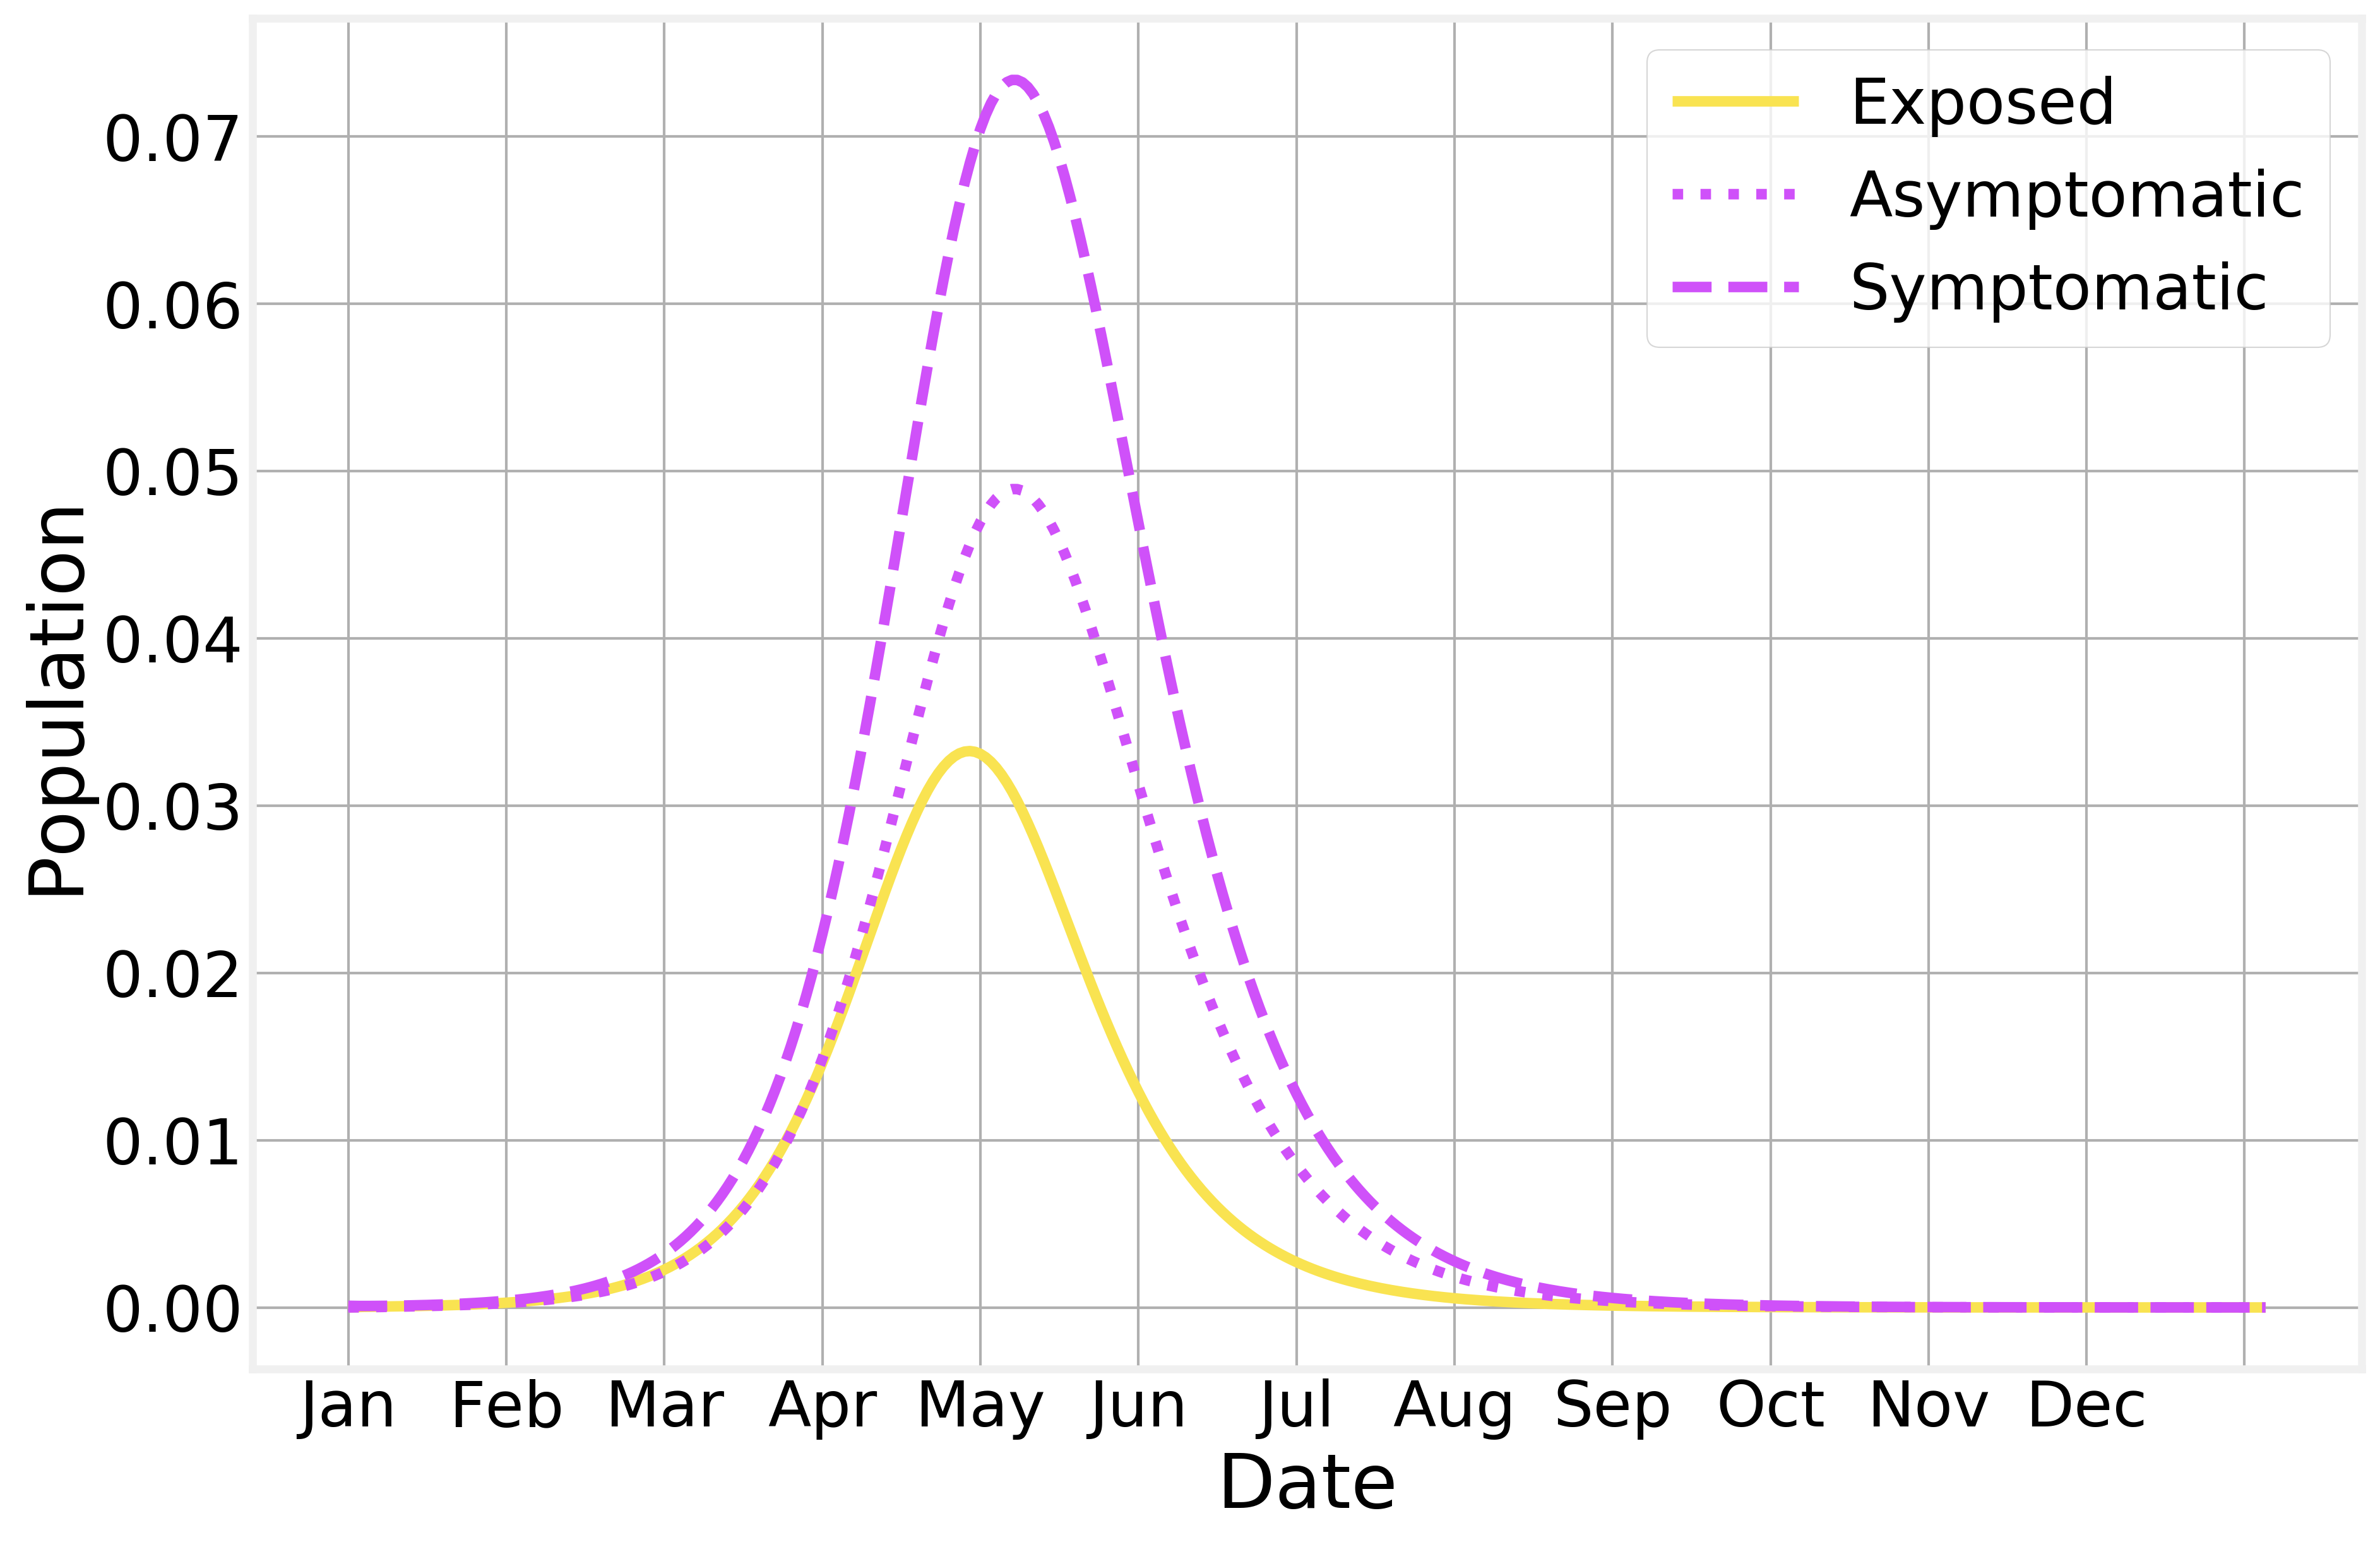

In [11]:
fig, ax = plt.subplots(1)
(non_seasonal.E/N).plot(color=colors[4], linestyle='-', label='Exposed', ax=ax)
(non_seasonal.Ia/N).plot(color=colors[1], linestyle=':', label='Asymptomatic', ax=ax)
(non_seasonal.Is/N).plot(color=colors[1], linestyle='--', label='Symptomatic', ax=ax)

ax.set_xticks(np.arange(1, 366, 30))
ax.set_xticklabels(months)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Population')

## Regular seasonality

Now we integrate the same model but using the norhern and souther seasonalities. We should note that if we don't specify when the seeding occurs, it is set to Jan 1 by default. To define the first day we use the __t_min__ parameter in __integrate()__. We set t_min=60 (March 1st)

In [12]:
SEIIRD.integrate(365, t_min=60, seasonality=seasonality(t_max=15), S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
seasonal_north = SEIIRD.values_.copy()

SEIIRD.integrate(365, t_min=60, seasonality=seasonality(t_max=195), S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
seasonal_south = SEIIRD.values_.copy()

Text(0, 0.5, 'Symptomatic Population')

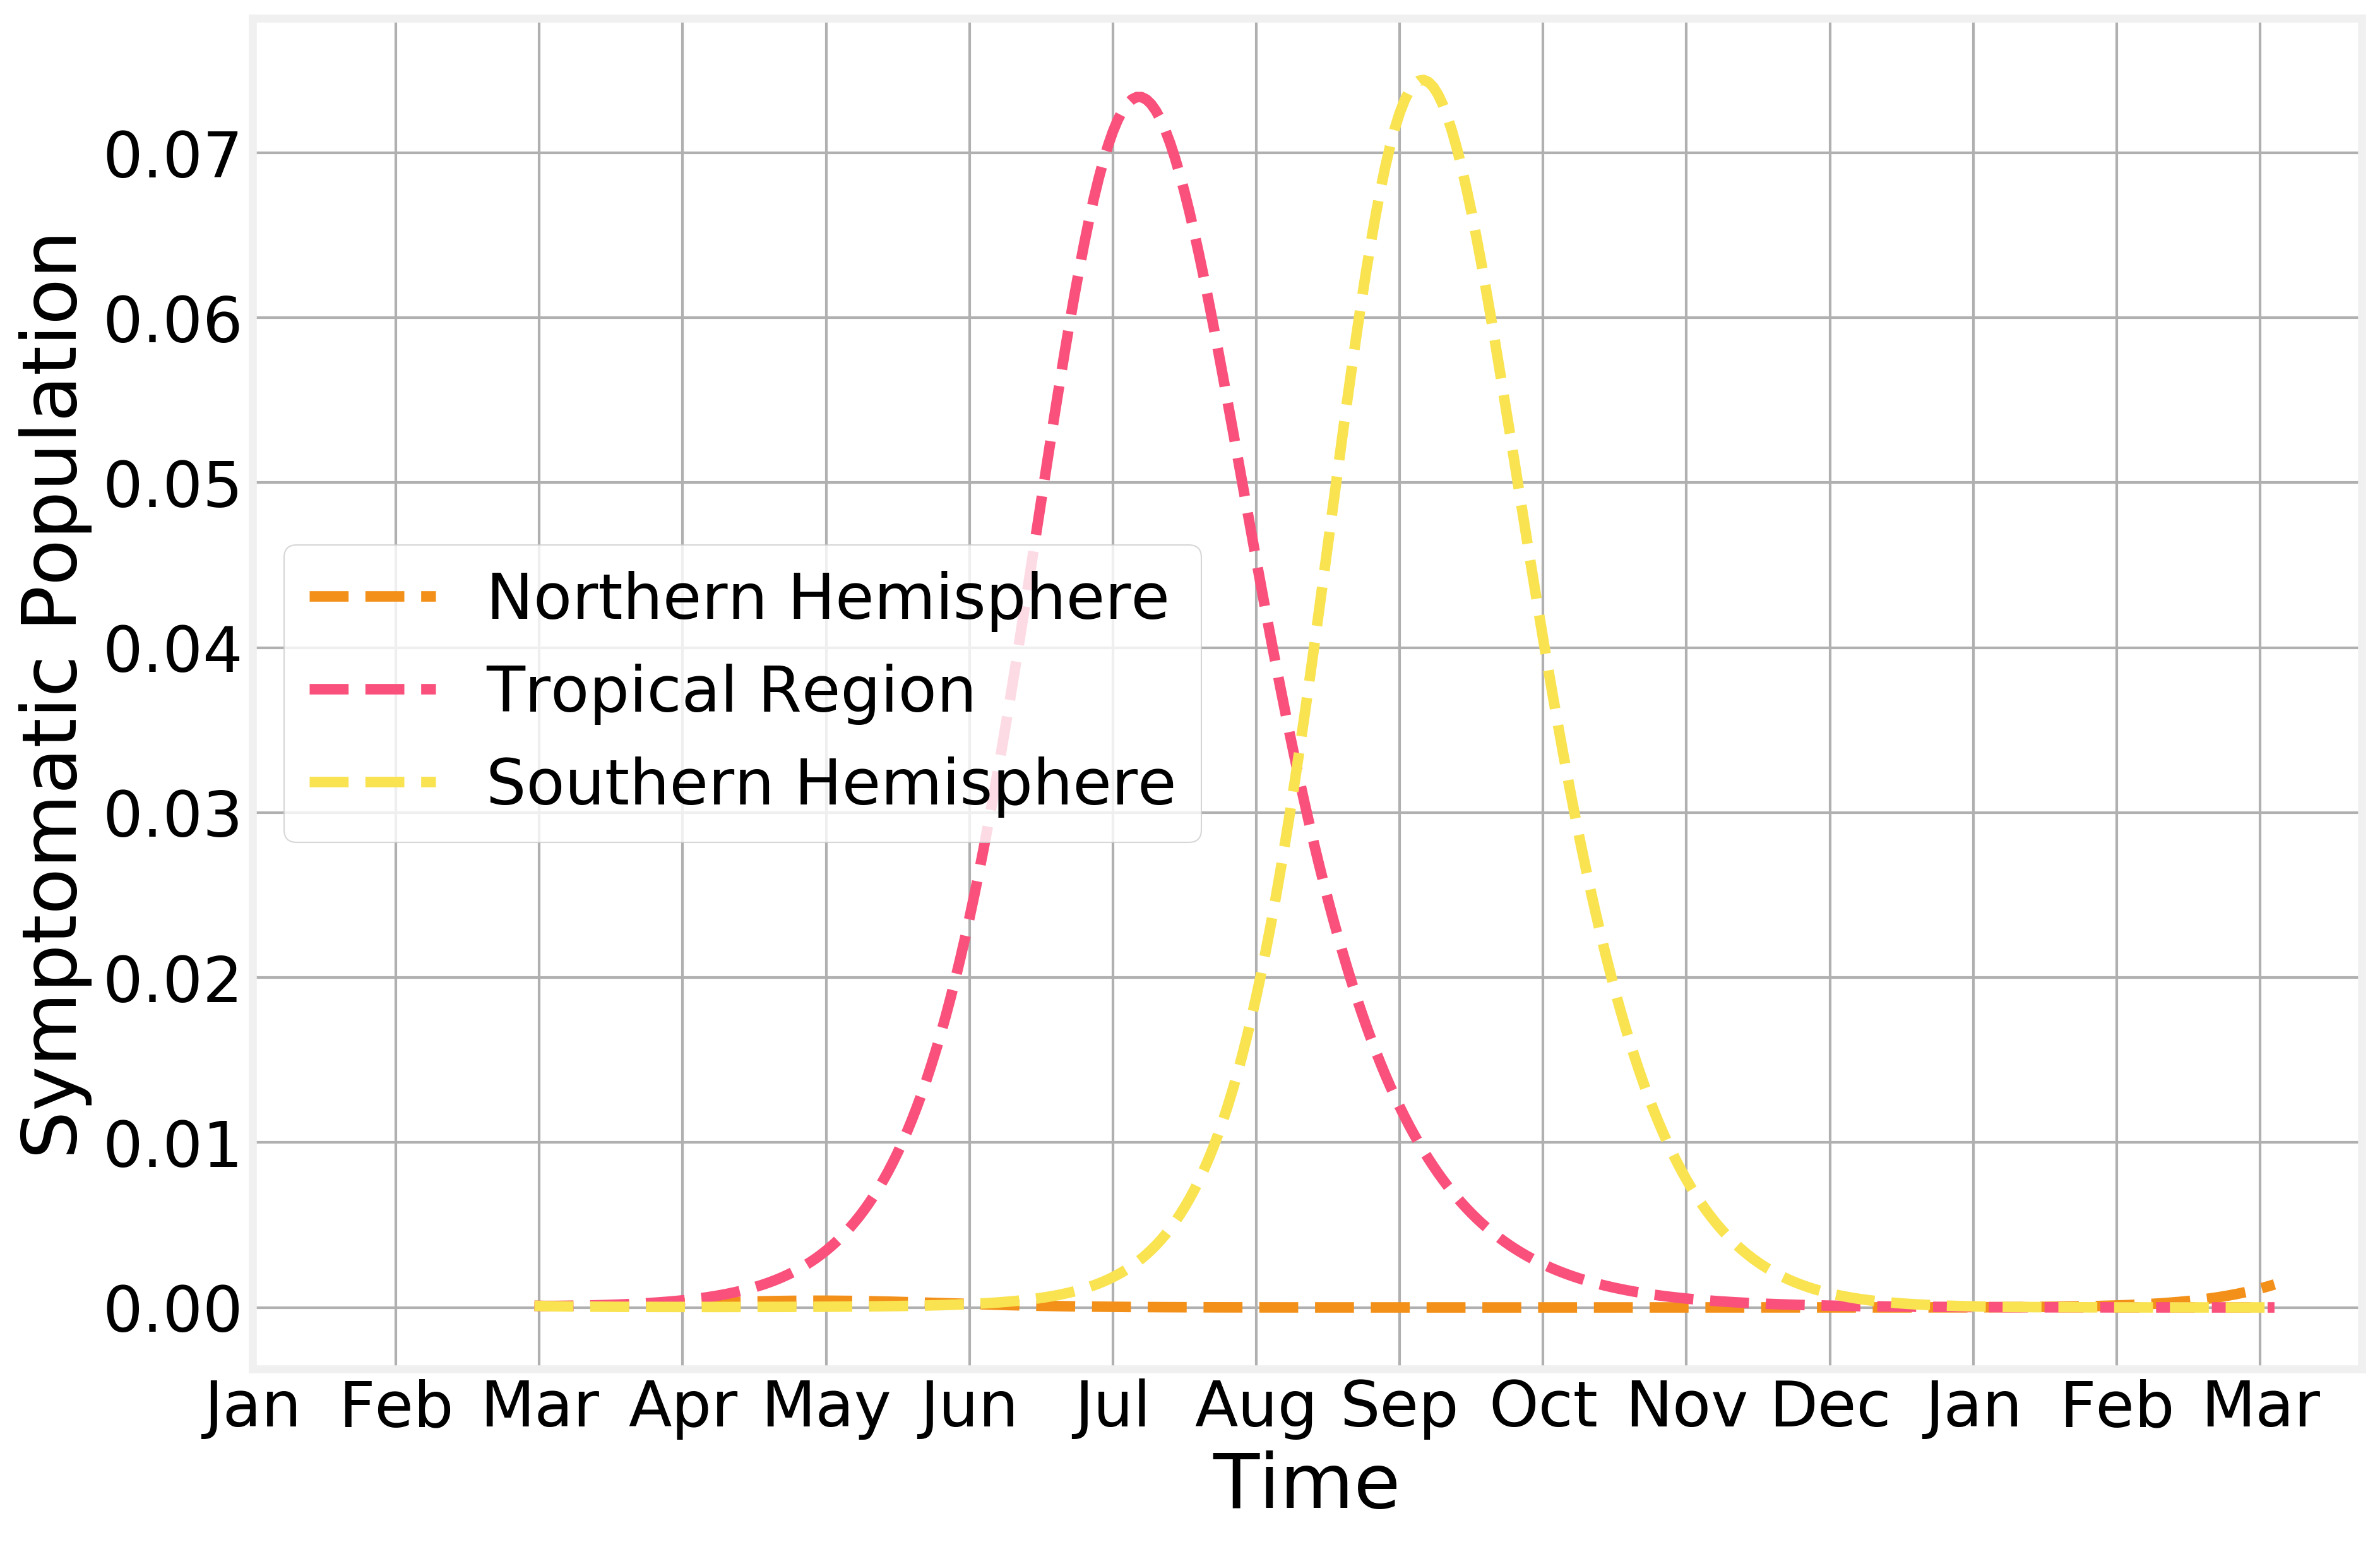

In [13]:
fig, ax = plt.subplots(1)

ax.plot(np.arange(60, 366+59), seasonal_north.Is/N, color=colors[3], linestyle='--', label='Northern Hemisphere')
ax.plot(np.arange(60, 366+59), non_seasonal.Is/N, color=colors[5], linestyle='--', label='Tropical Region')
ax.plot(np.arange(60, 366+59), seasonal_south.Is/N, color=colors[4], linestyle='--', label='Southern Hemisphere')

ax.set_xticks(np.arange(1, 366+60, 30))
ax.set_xticklabels(months_extended)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Symptomatic Population')

Here we note that the regular seasonality is enough to simply kill the epidemic in the northern hemisphere. As we're currently experiencing, this is not entirely realistic, so we expect that it is less sensitive to seasonal effects than the regular flu.

## Reduced seasonality

If however, we assume that the SARS-CoV-2 epidemic follows the same pattern as the 2009/H1N1pdm, then we have:

In [14]:
SEIIRD.integrate(365, t_min=60, seasonality=seasonality(a_min=0.65, t_max=15), S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
h1n1_north = SEIIRD.values_.copy()

SEIIRD.integrate(365, t_min=60, seasonality=seasonality(a_min=0.65, t_max=195), S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
h1n1_south = SEIIRD.values_.copy()

And now we see how the seasonality can be the main driving factor for the way in which the epidemic behaves. In this case, we have the reduced seasonality essentailly stretching the epidemic curve over several months across the Fall and Winter

Text(0, 0.5, 'Symptomatic Population')

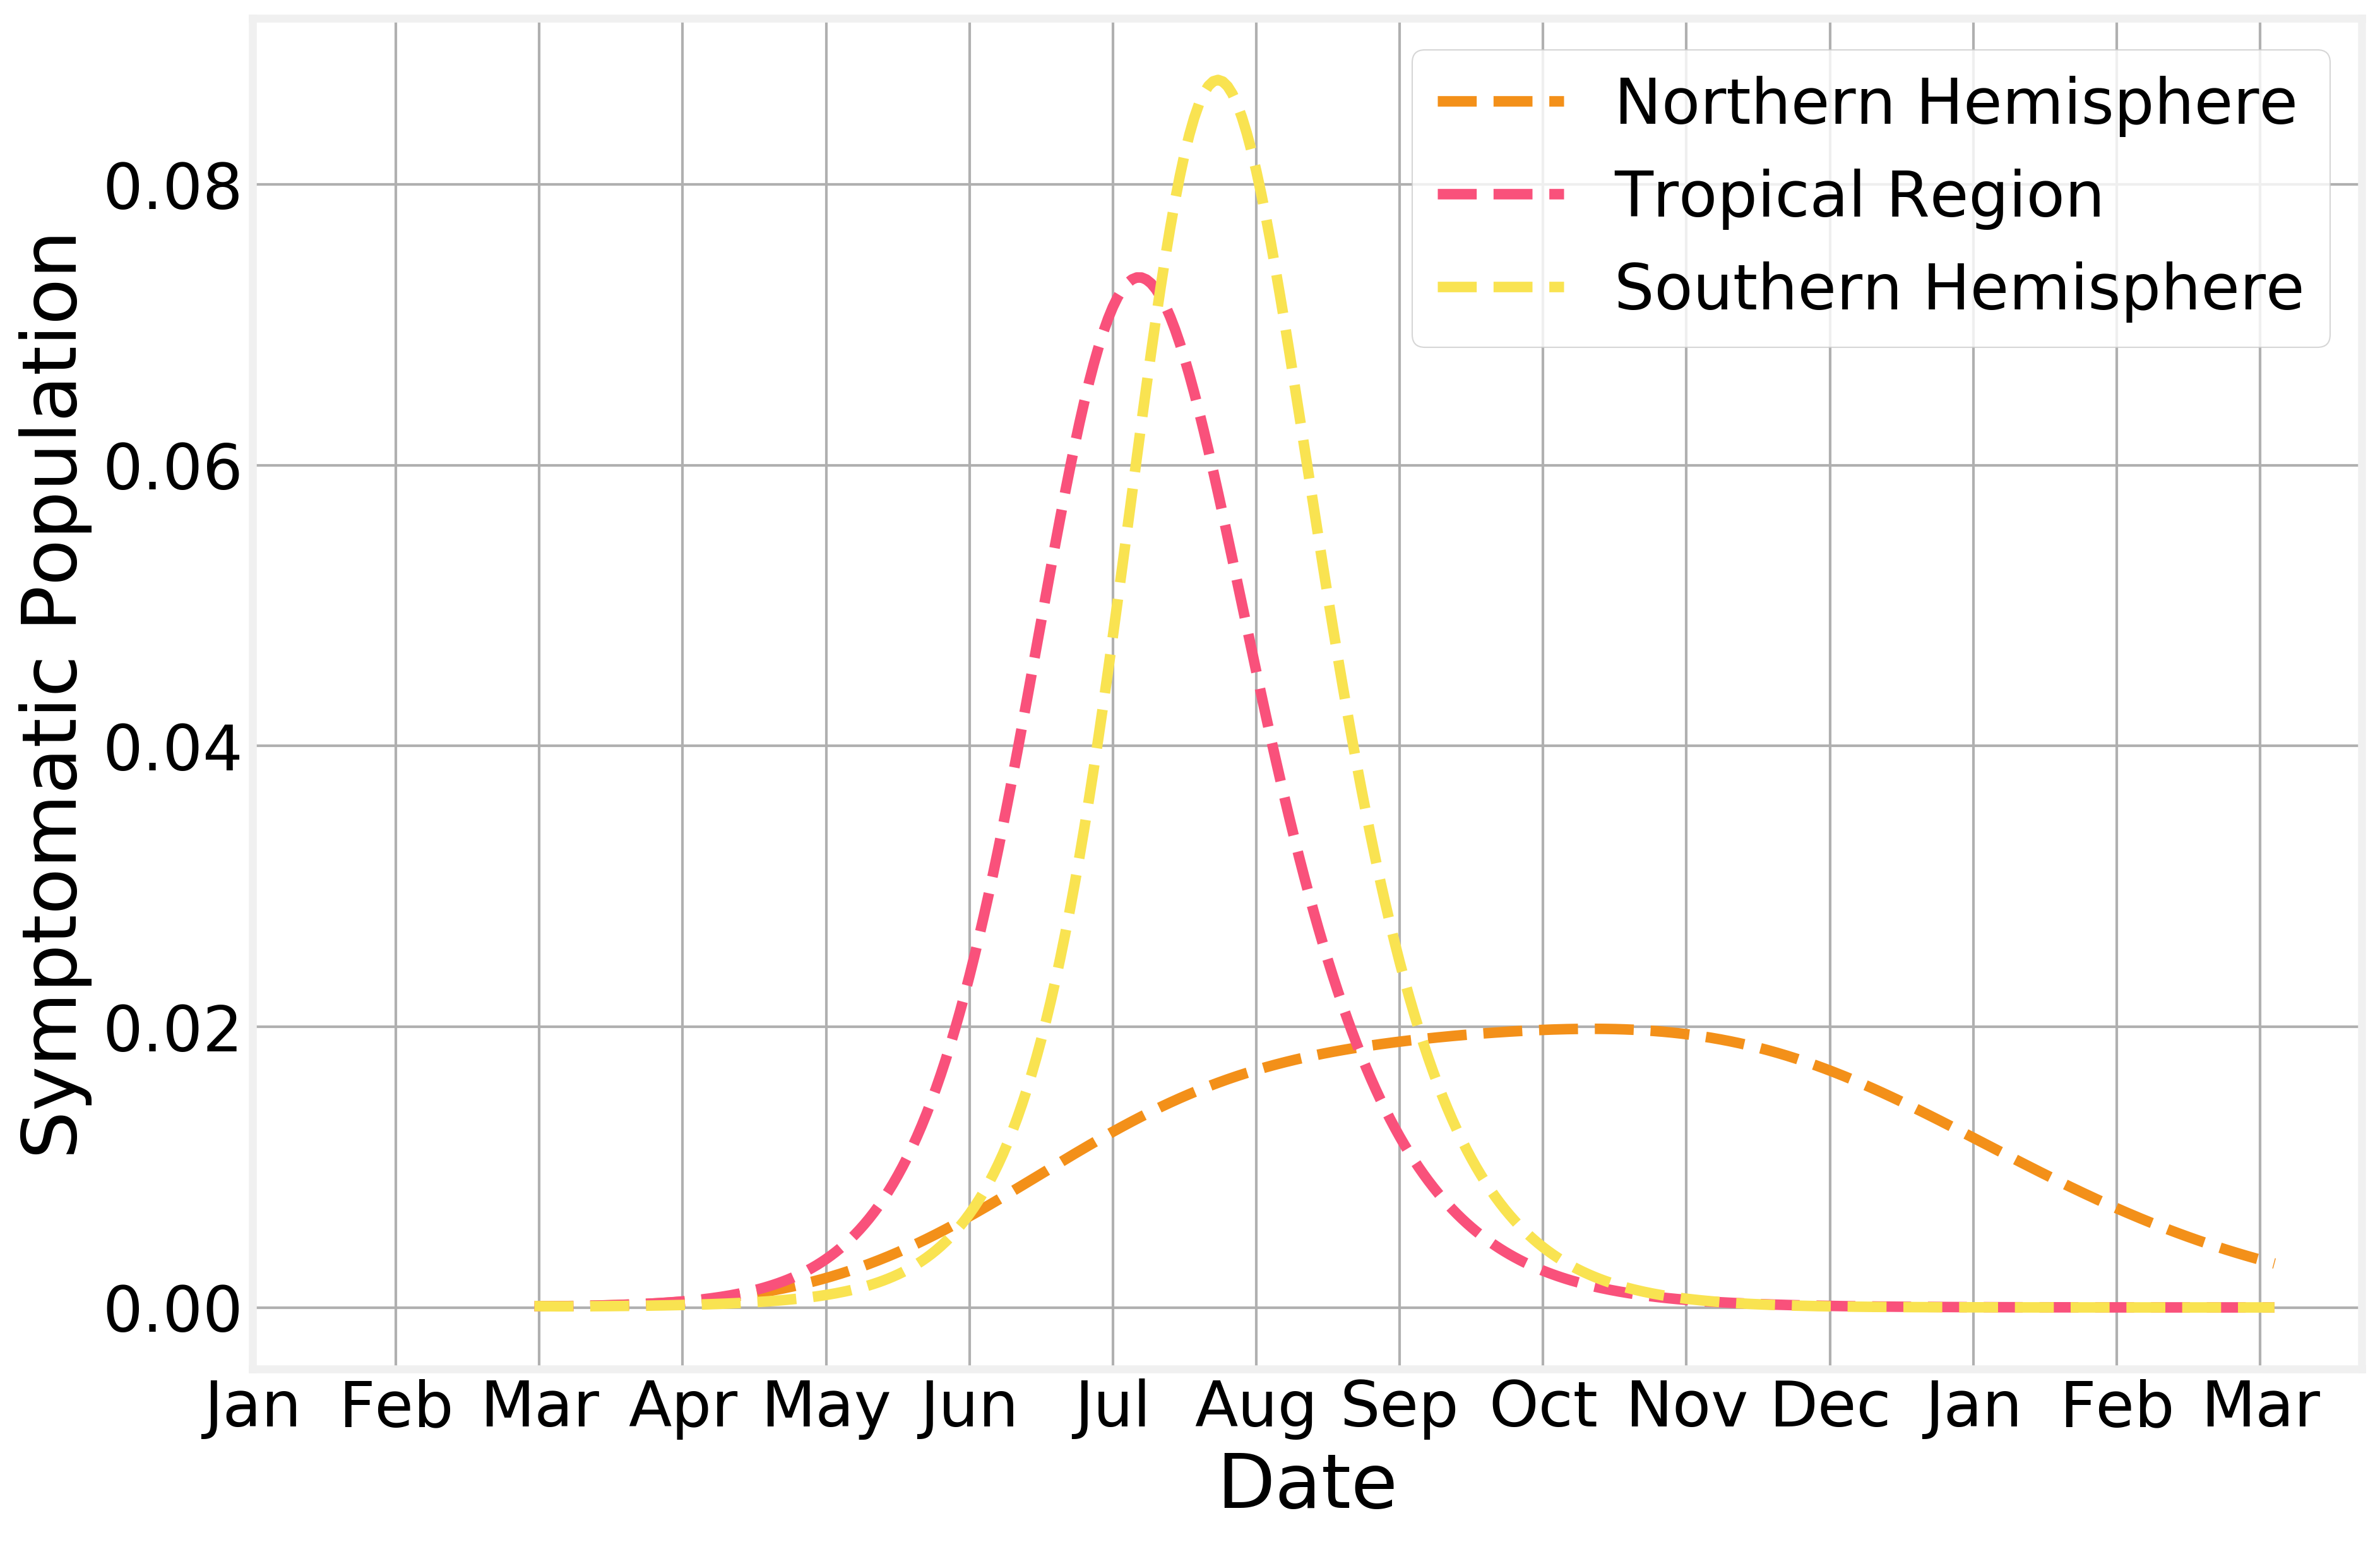

In [15]:
fig, ax = plt.subplots(1)

ax.plot(h1n1_north.index, h1n1_north.Is/N, color=colors[3], linestyle='--', label='Northern Hemisphere')
ax.plot(non_seasonal.index+59, non_seasonal.Is/N, color=colors[5], linestyle='--', label='Tropical Region')
ax.plot(h1n1_south.index, h1n1_south.Is/N, color=colors[4], linestyle='--', label='Southern Hemisphere')

ax.set_xticks(np.arange(1, h1n1_south.index.max(), 30))
ax.set_xticklabels(months_extended)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Symptomatic Population')

## Comparison

Text(0.5, 1.0, 'Northern Hemisphere')

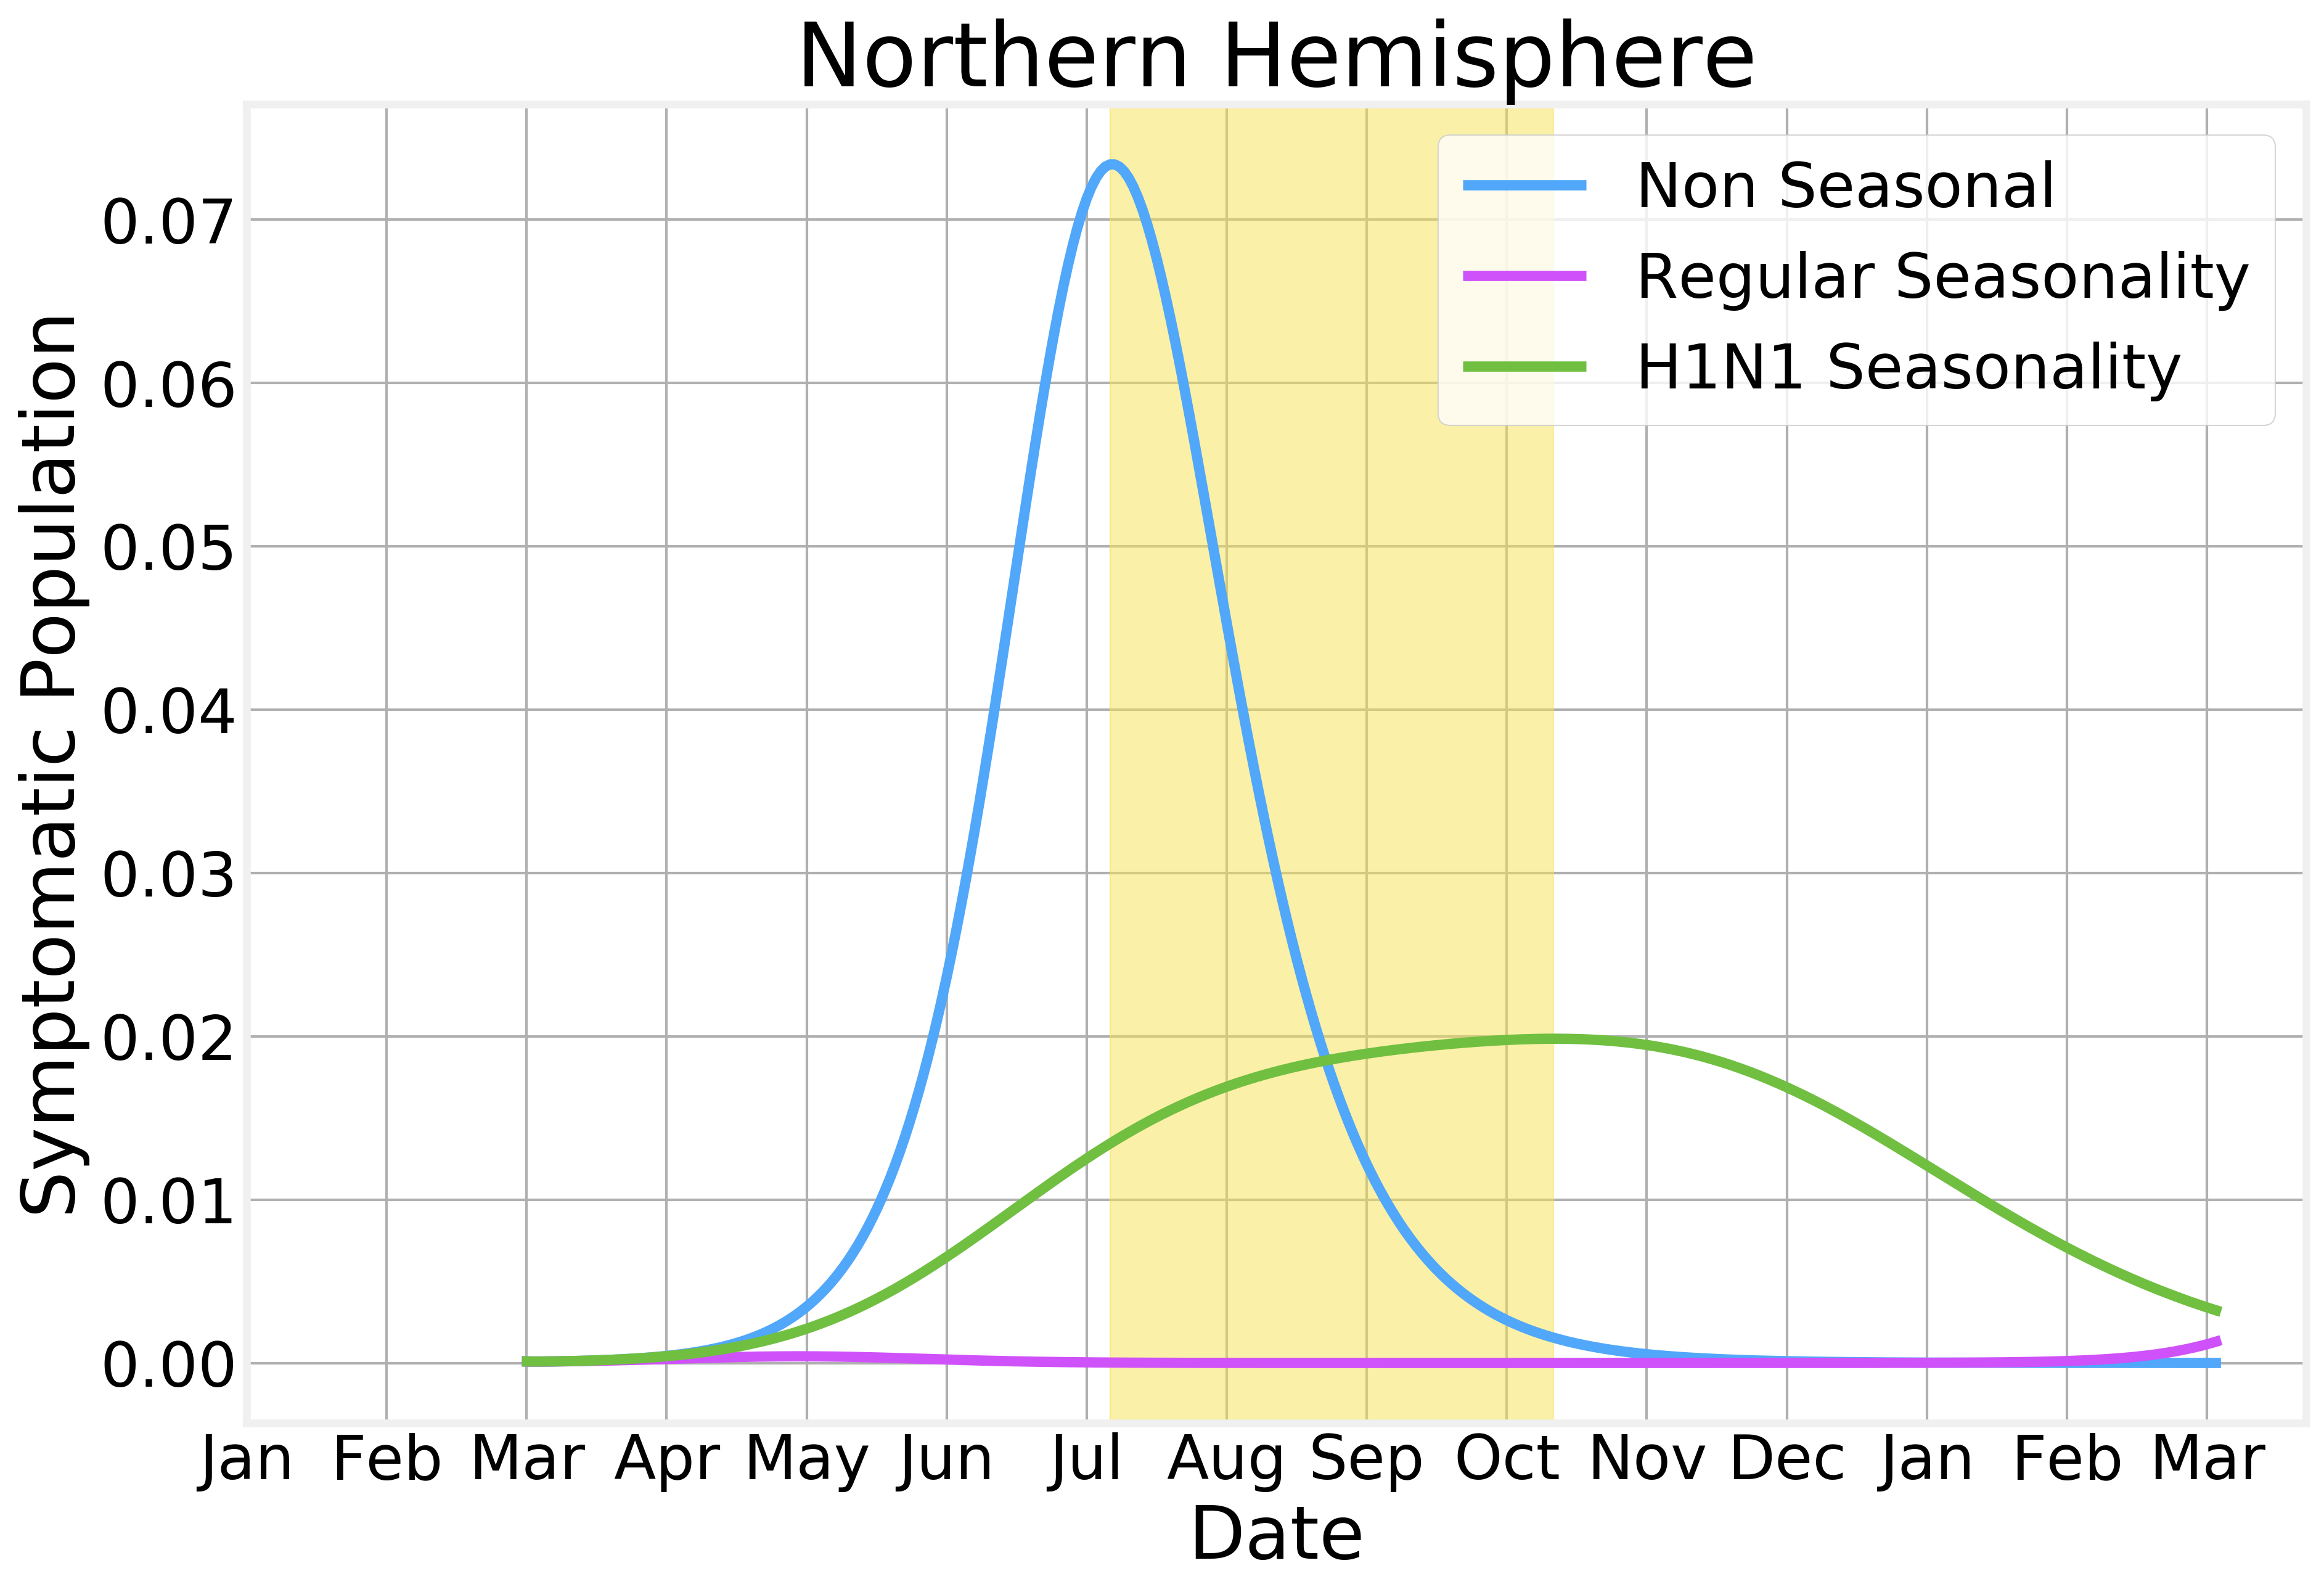

In [16]:
fig, ax = plt.subplots(1)

ax.plot(non_seasonal.index+59, non_seasonal.Is/N, linestyle='-', c=colors[0], label='Non Seasonal')
ax.plot(seasonal_north.index, seasonal_north.Is/N, linestyle='-', c=colors[1], label='Regular Seasonality')
ax.plot(h1n1_north.index, h1n1_north.Is/N, linestyle='-', c=colors[2], label='H1N1 Seasonality')

peak_regular = non_seasonal.Is.idxmax()+59
peak_h1n1 = h1n1_north.Is.idxmax()
ax.axvspan(xmin=peak_regular, xmax=peak_h1n1, color=colors[4], alpha=0.5)

ax.set_xticks(np.arange(1, h1n1_north.index.max(), 30))
ax.set_xticklabels(months_extended)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Symptomatic Population')
ax.set_title('Northern Hemisphere')

Text(0.5, 1.0, 'Southern Hemisphere')

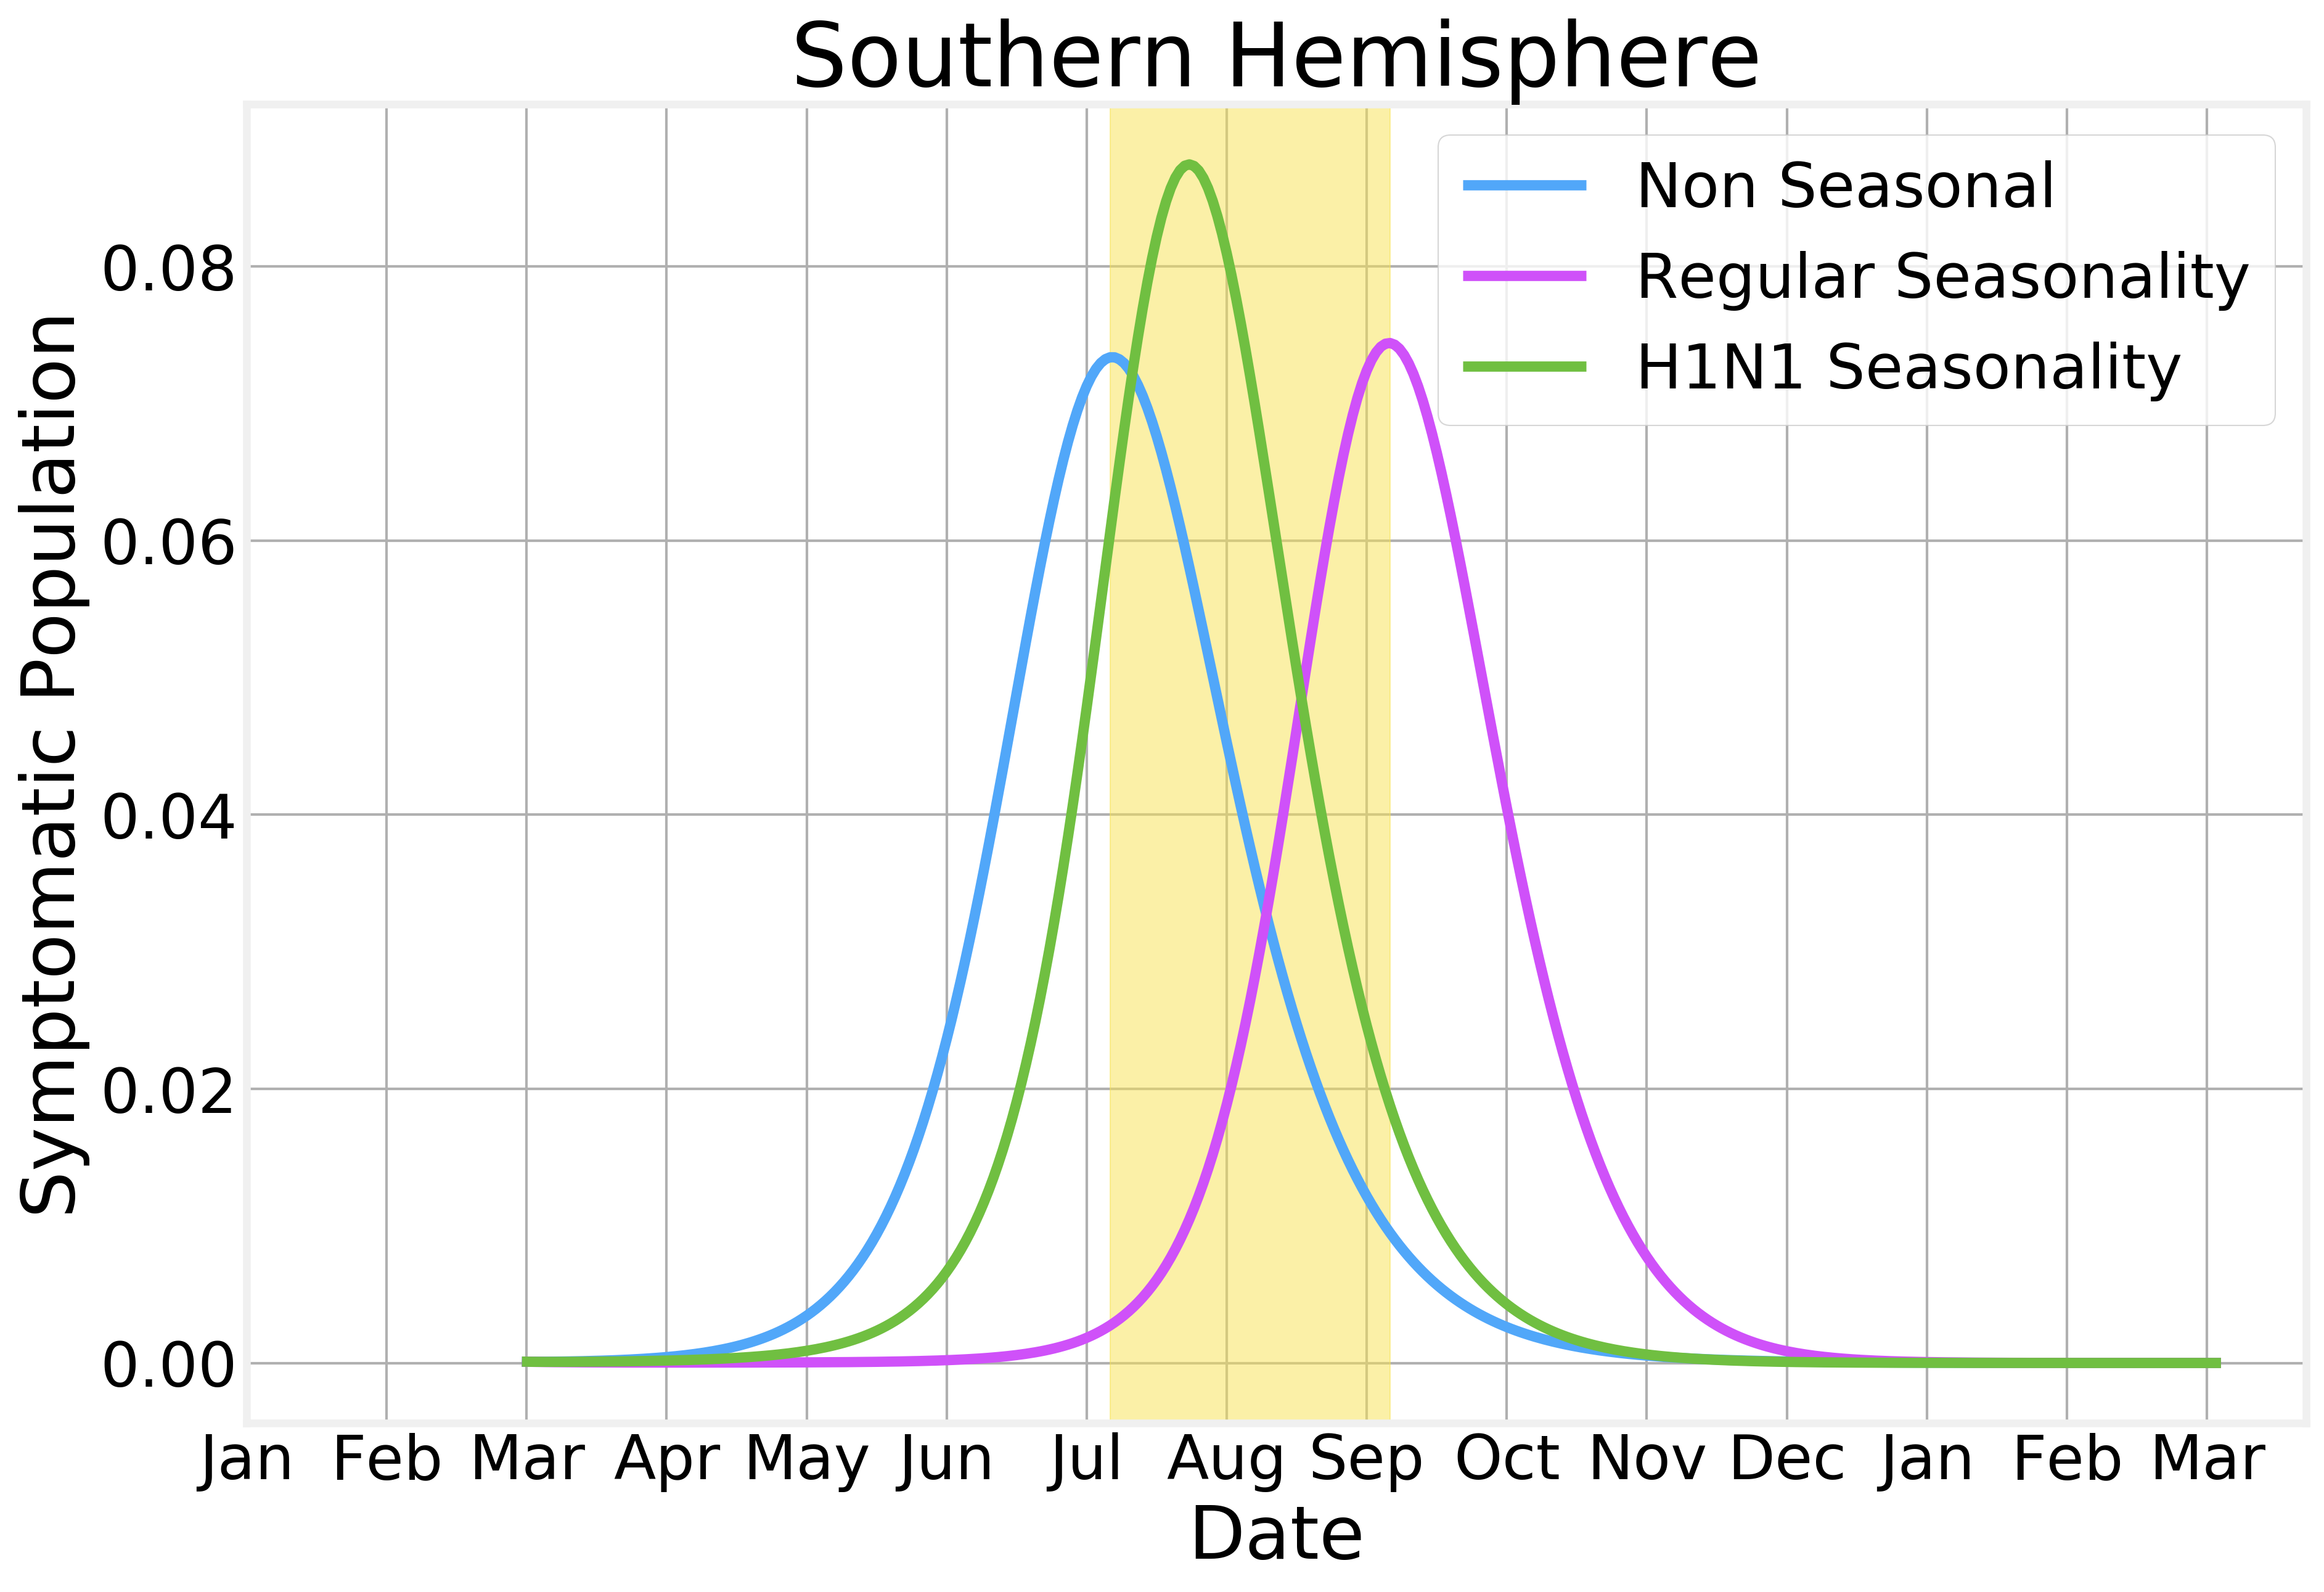

In [17]:
fig, ax = plt.subplots(1)

ax.plot(non_seasonal.index+59, non_seasonal.Is/N, linestyle='-', c=colors[0], label='Non Seasonal')
ax.plot(seasonal_south.index, seasonal_south.Is/N, linestyle='-', c=colors[1], label='Regular Seasonality')
ax.plot(h1n1_south.index, h1n1_south.Is/N, linestyle='-', c=colors[2], label='H1N1 Seasonality')

peak_regular = non_seasonal.Is.idxmax()+59
peak_seasonal = seasonal_south.Is.idxmax()
ax.axvspan(xmin=peak_regular, xmax=peak_seasonal, color=colors[4], alpha=0.5)

ax.set_xticks(np.arange(1, h1n1_south.index.max(), 30))
ax.set_xticklabels(months_extended)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Symptomatic Population')
ax.set_title('Southern Hemisphere')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>